# 使用ICA减少伪影

本节将展示如何使用独立成分分析（ICA）方法来抑制眼部和心脏伪影。这将通过首先执行数据的ICA分解来完成，之后手动识别反映伪影的分量。作为最后一步，伪迹成分被“投影出来”

## Preparation

Important the relevant Python modules:

In [4]:
import os.path as op
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne_bids import BIDSPath, read_raw_bids
from mne.preprocessing import ICA

### File overview
The chapter relies on the input files (embedded in the BIDS structure):
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif
~~~
and generates the output files:
~~~
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ica.fif
<BIDS_ROOT>/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif
~~~

Set the local paths to the data:

In [14]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '02'
meg_suffix = 'meg'
ann_suffix = 'ann'
ica_suffix = 'ica'
ann_suffix = 'ann'

deriv_root = '/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing'

bids_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=ann_suffix, 
            root=deriv_root, extension='.fif', check=False)

deriv_fname = bids_path.basename.replace(ann_suffix, ica_suffix)
deriv_file_1 = op.join(bids_path.directory, deriv_fname)
deriv_file_2 = deriv_file_1.replace('run-01', 'run-02')
deriv_files = [deriv_file_1, deriv_file_2]  

print(bids_path)
print(deriv_file_1)

/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif
/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif


### 原始数据的重新采样和过滤

为了有效地进行ICA分解并将所有子数据集保存在内存中，我们将首先对数据进行下采样。我们将使用应用SSS和注释的数据集。然后，我们将应用重采样函数将数据下采样到200赫兹，然后应用1-40赫兹带通滤波器。1Hz高通对于去除慢漂移是重要的，否则慢漂移会使ICA分解的效率降低。在这些操作之后，数据集被级联，使得可以在一次命中中对数据集执行ICA。

In [15]:
raw = read_raw_bids(bids_path=bids_path, 
                     extra_params={'preload':True},
                     verbose=True)
raw_resmpl = raw.copy().pick('meg')
raw_resmpl.resample(200) # dowsample to 200 Hz
raw_resmpl.filter(1, 40) # band-pass filtert from 1 to 40 Hz
raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl])
del raw_resmpl

Opening raw data file /home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...


/tmp/ipykernel_740773/2011916169.py:1: RuntimeWarning: This filename (/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path,
/tmp/ipykernel_740773/2011916169.py:1: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path,
/tmp/ipykernel_740773/2011916169.py:1: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/**/meg/sub-01_ses

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    1.4s


In [11]:
for subfile in range(2):
    raw = read_raw_bids(bids_path=bids_path, 
                     extra_params={'preload':True},
                     verbose=True)
    raw_resmpl = raw.copy().pick('meg')
    raw_resmpl.resample(200) # dowsample to 200 Hz
    raw_resmpl.filter(1, 40) # band-pass filtert from 1 to 40 Hz
    if subfile == 0:
        raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl])
        bids_path.update(run='02')
    else:
        raw_resmpl_all = mne.io.concatenate_raws([raw_resmpl_all, raw_resmpl])
del raw_resmpl

FileNotFoundError: File does not exist:
/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann.fif
Did you mean one of:
sub-01_ses-01_task-SpAtt_run-02_ann.fif
sub-01_ses-01_task-SpAtt_run-02_ann.csv
sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
instead of:
sub-01_ses-01_task-SpAtt_run-01_ann.fif

### 应用ICA算法
现在我们应用ICA算法。我们选择了*fastica*方法，因为它已经建立并广泛使用。但是，MNE Python中也提供了其他ICA方法。为了加快计算，我们选择将ICA限制为最初的30个分量。

In [16]:
ica = ICA(method='fastica',
    random_state=97,
    n_components=30,
    verbose=True)

ica.fit(raw_resmpl_all,
    verbose=True)

Fitting ICA to data using 306 channels (please be patient, this may take a while)
Omitting 8345 of 286800 (2.91%) samples, retaining 278455 (97.09%) samples.
Selecting by number: 30 components
Fitting ICA took 10.7s.


<ICA | raw data decomposition, method: fastica (fit in 59 iterations on 278455 samples), 30 ICA components (306 PCA components available), channel types: mag, grad, no sources marked for exclusion>

### 识别反映伪影的ICA分量

要绘制ICA组件的时间轨迹示例，请使用：

Creating RawArray with float64 data, n_channels=30, n_times=286800
    Range : 333000 ... 619799 =   1665.000 ...  3098.995 secs
Ready.


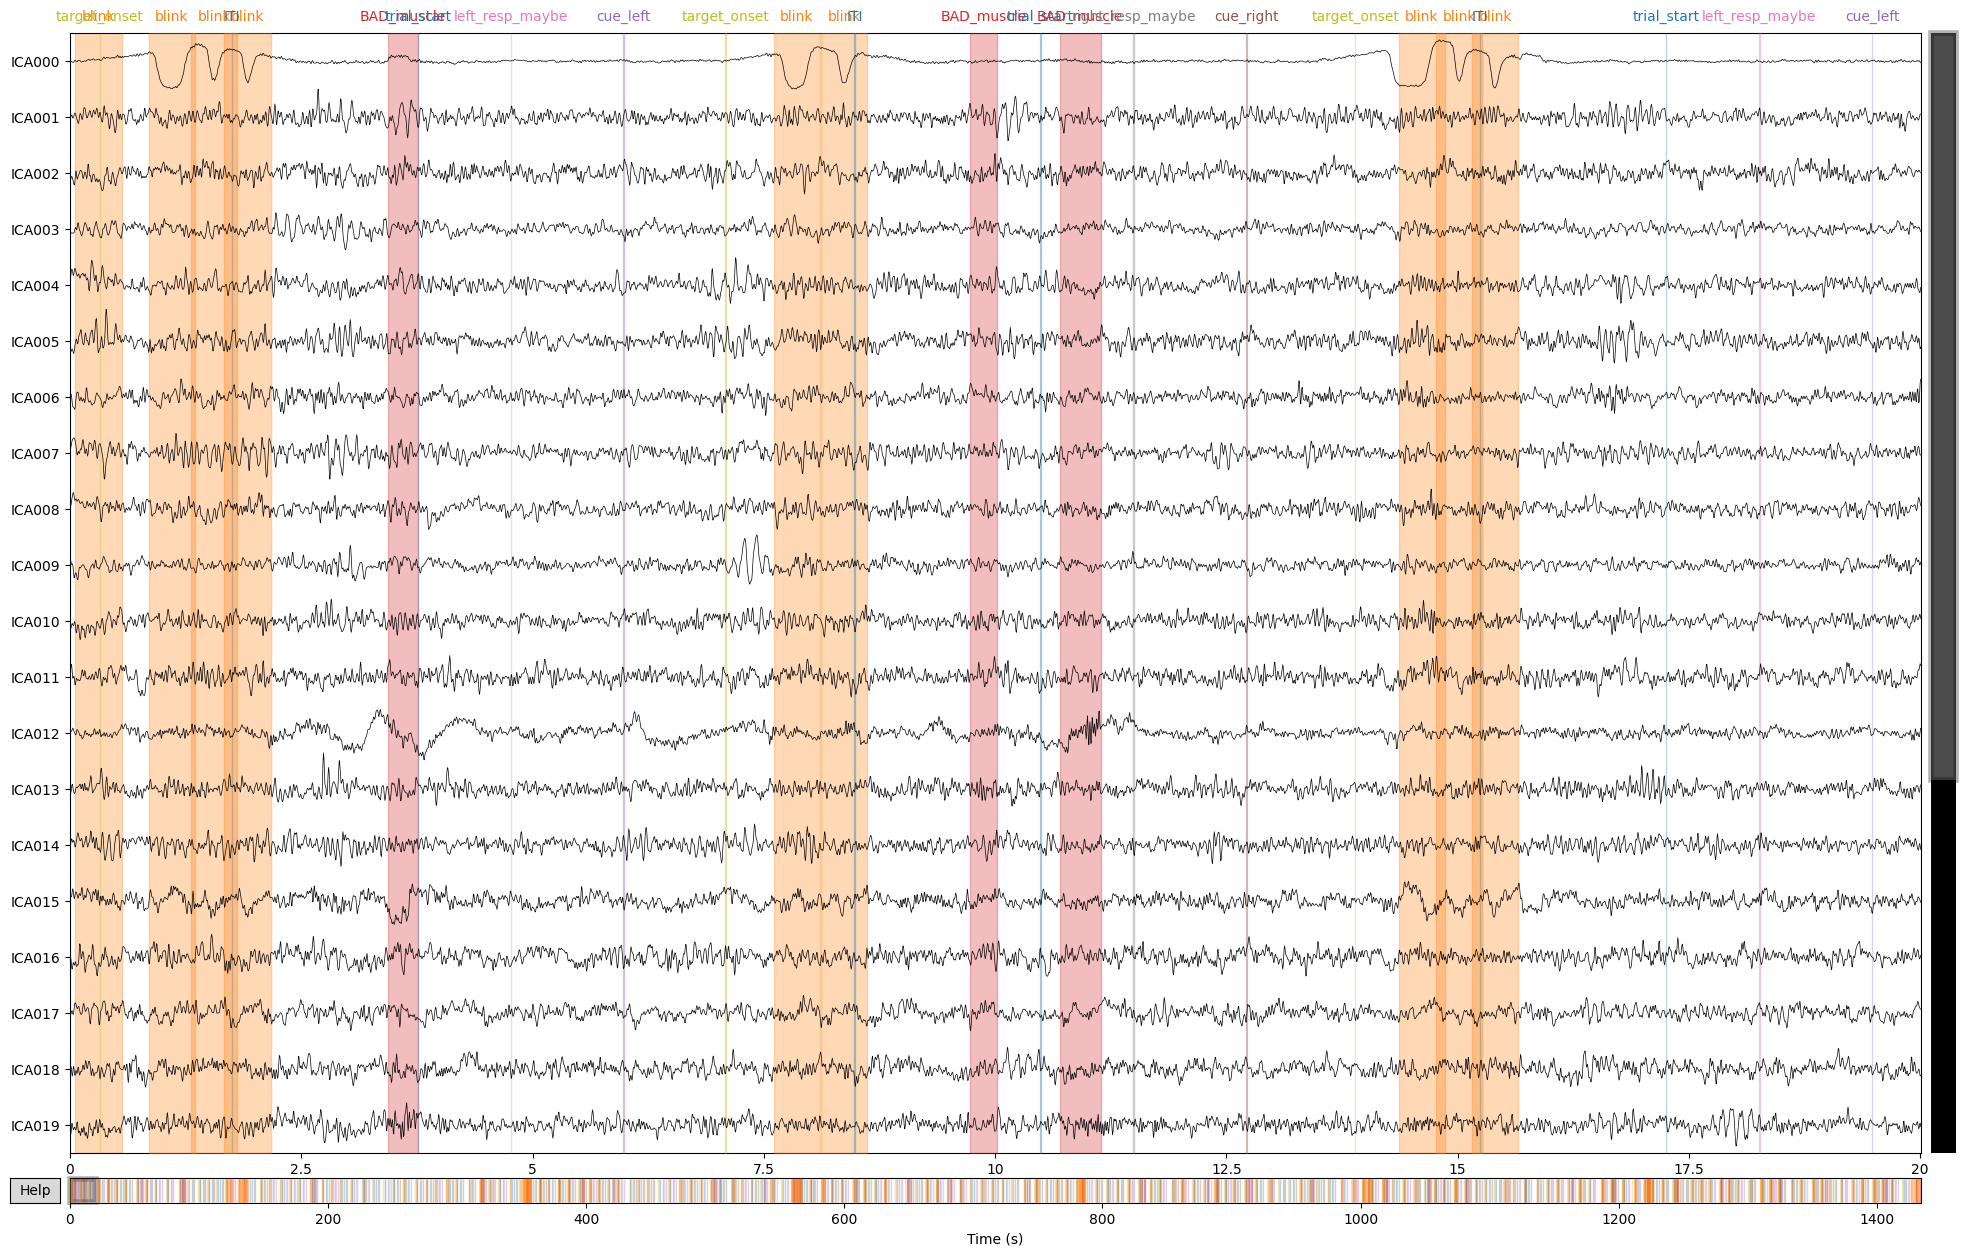

In [17]:
%matplotlib inline
ica.plot_sources(raw_resmpl_all, title='ICA');

使用左/右箭头键滚动数据，使用上/下箭头键滚动组件。右键单击IC名称以查看相关的地形图和其他详细信息。

这里的分析是基于Run='01'数据的，上面运行的结果是Run='02'的，因此不具备参考性
> 在检查痕迹时，可以清楚地看出，ICA000和ICA001对眨眼的反射最强烈。成分ICA015反映扫视。最后，ICA023反映了心电图。

ICA分量的这种顺序特定于该数据集和用于ICA分解的种子（*random_state*）。对于其他数据集或使用不同的种子，组件将以不同的顺序出现。因此，必须手动识别与伪迹相关联的组件。

**问题1:** 估计心率的频率

**问题2:** 识别ICA015中的扫视

要显示每个ICA组件的拓扑图，请编写：

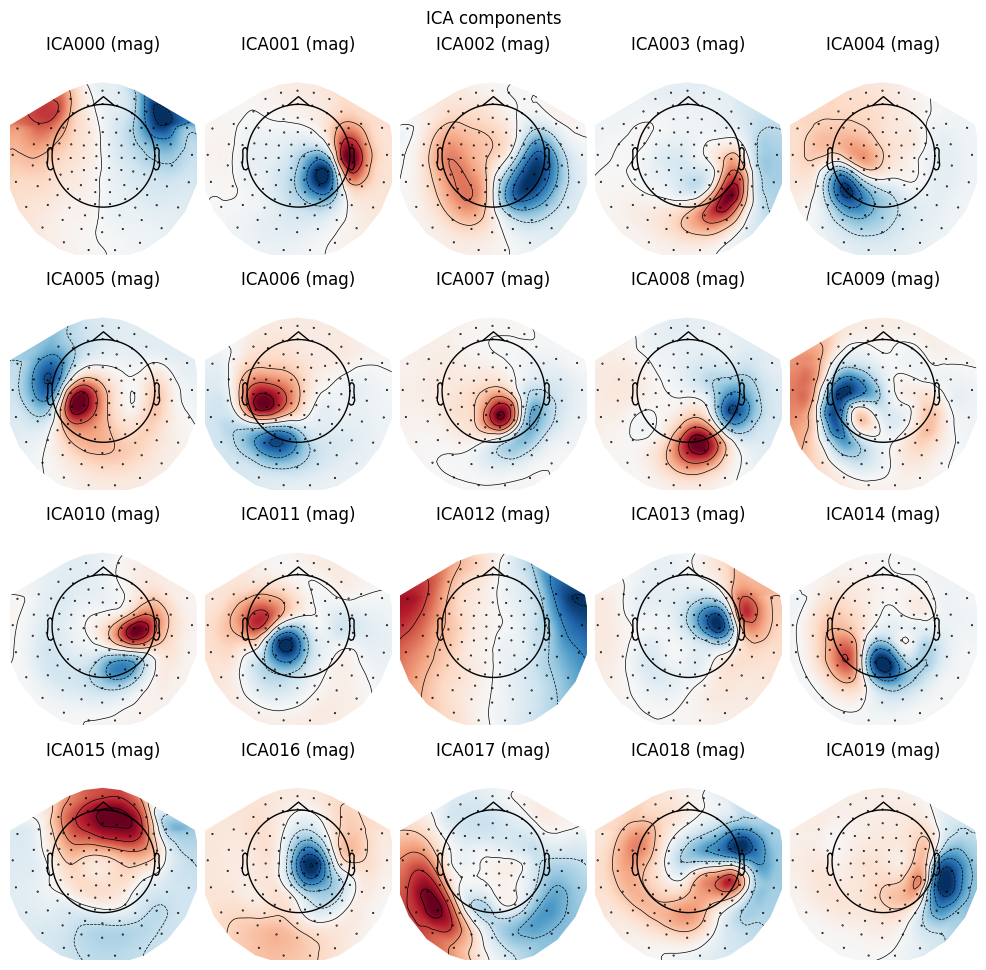

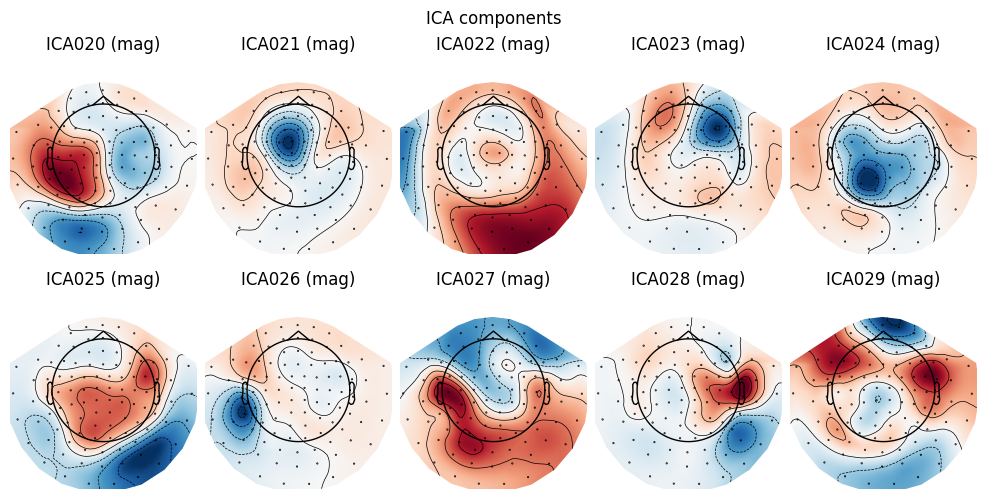

In [18]:
%matplotlib inline
ica.plot_components();

同上
> 这些图显示了与磁力计相关的地形，因为它们更容易解释。ICA000和ICA001的形貌看起来像一个经典的眨眼伪影，在相反极性的左侧和右侧额叶传感器上具有强烈的活动。ICA015的正面负性与扫视有关。ICA023看起来像一个典型的心电图伪影，通过源自环绕心脏的磁场的边缘传感器的强烈活动来观察。

通常应拆除多少个部件？根据经验，不超过一把（5个？）。通常仅去除清楚地反映生理假象的成分。去除过多的成分可能也会影响大脑活动。

**问题3:** 哪种成分可能反映了人类α带的活动？把你的论点建立在痕迹和地形的基础上。


### 通过应用投影来减弱伪影

既然我们已经检测到了与眼睛和心脏伪影相关的ICA成分，我们就必须“投射”出来。这将通过将*ICA.exclude*生成的ICA投影应用于原始原始数据来完成，原始数据将通过循环子文件再次加载。应用ICA投影（*ICA.apply*）后，将保存数据。

In [ ]:
# Set the 4 components to exclude
ica.exclude = [0, 1, 15, 23] # 按照run=01数据排除的ica成分

# Loop over the subfiles
# for subfile in range(2):
#     if subfile == 1:
bids_path.update(run='02')

raw_ica = read_raw_bids(bids_path=bids_path,
                    extra_params={'preload':True},
                    verbose=True)
ica.apply(raw_ica)

raw_ica.save(deriv_files[subfile], overwrite=True)

Opening raw data file /home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...


/tmp/ipykernel_740773/2849861249.py:9: RuntimeWarning: This filename (/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ann.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ica = read_raw_bids(bids_path=bids_path,
/tmp/ipykernel_740773/2849861249.py:9: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw_ica = read_raw_bids(bids_path=bids_path,
/tmp/ipykernel_740773/2849861249.py:9: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-02.

The search_str was "/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/**/meg/su

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 306 PCA components
Writing /home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif


/tmp/ipykernel_740773/2849861249.py:14: RuntimeWarning: This filename (/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_ica.save(deriv_files[subfile], overwrite=True)


Closing /home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif
[done]


[PosixPath('/home/ubuntu/database/ds004346-FLUX/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_ica.fif')]

## 绘制数据以检查伪影减少情况

这里是子文件（#2）
> 我们将在这里检查其中一个子文件（#1）的一些痕迹，以证明伪影的减少。

定义几个正面磁力计以检查并包括EOG传感器：

In [ ]:
chs = ['MEG0311', 'MEG0121', 'MEG1211', 'MEG1411']
# 获取挑选的导联在原始数据中的索引
chan_idxs = [raw.ch_names.index(ch) for ch in chs] 
chan_idxs

[38, 17, 140, 164]

然后在应用ICA投影之前绘制数据。使用箭头按钮滚动浏览试次。

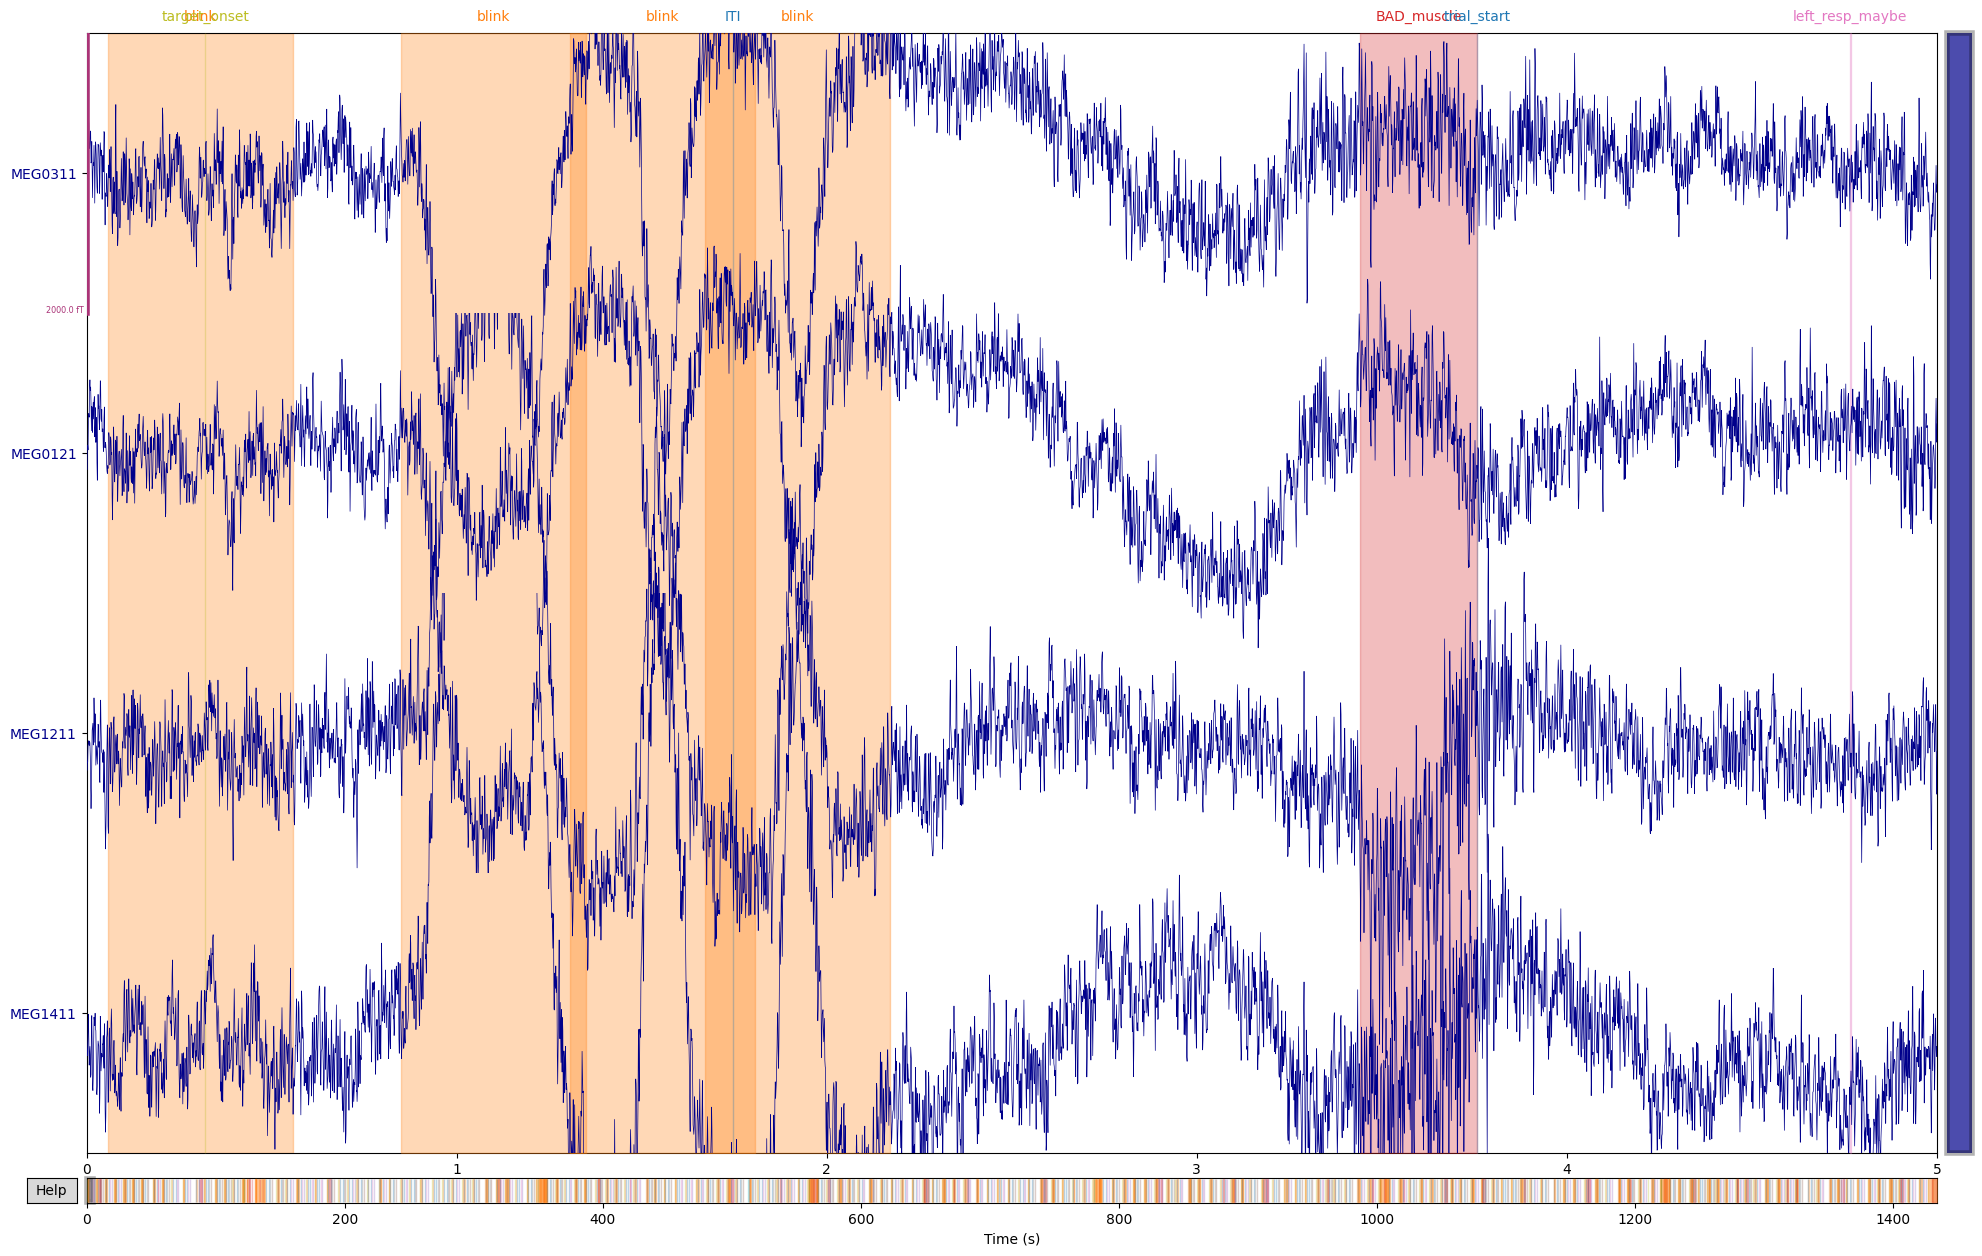

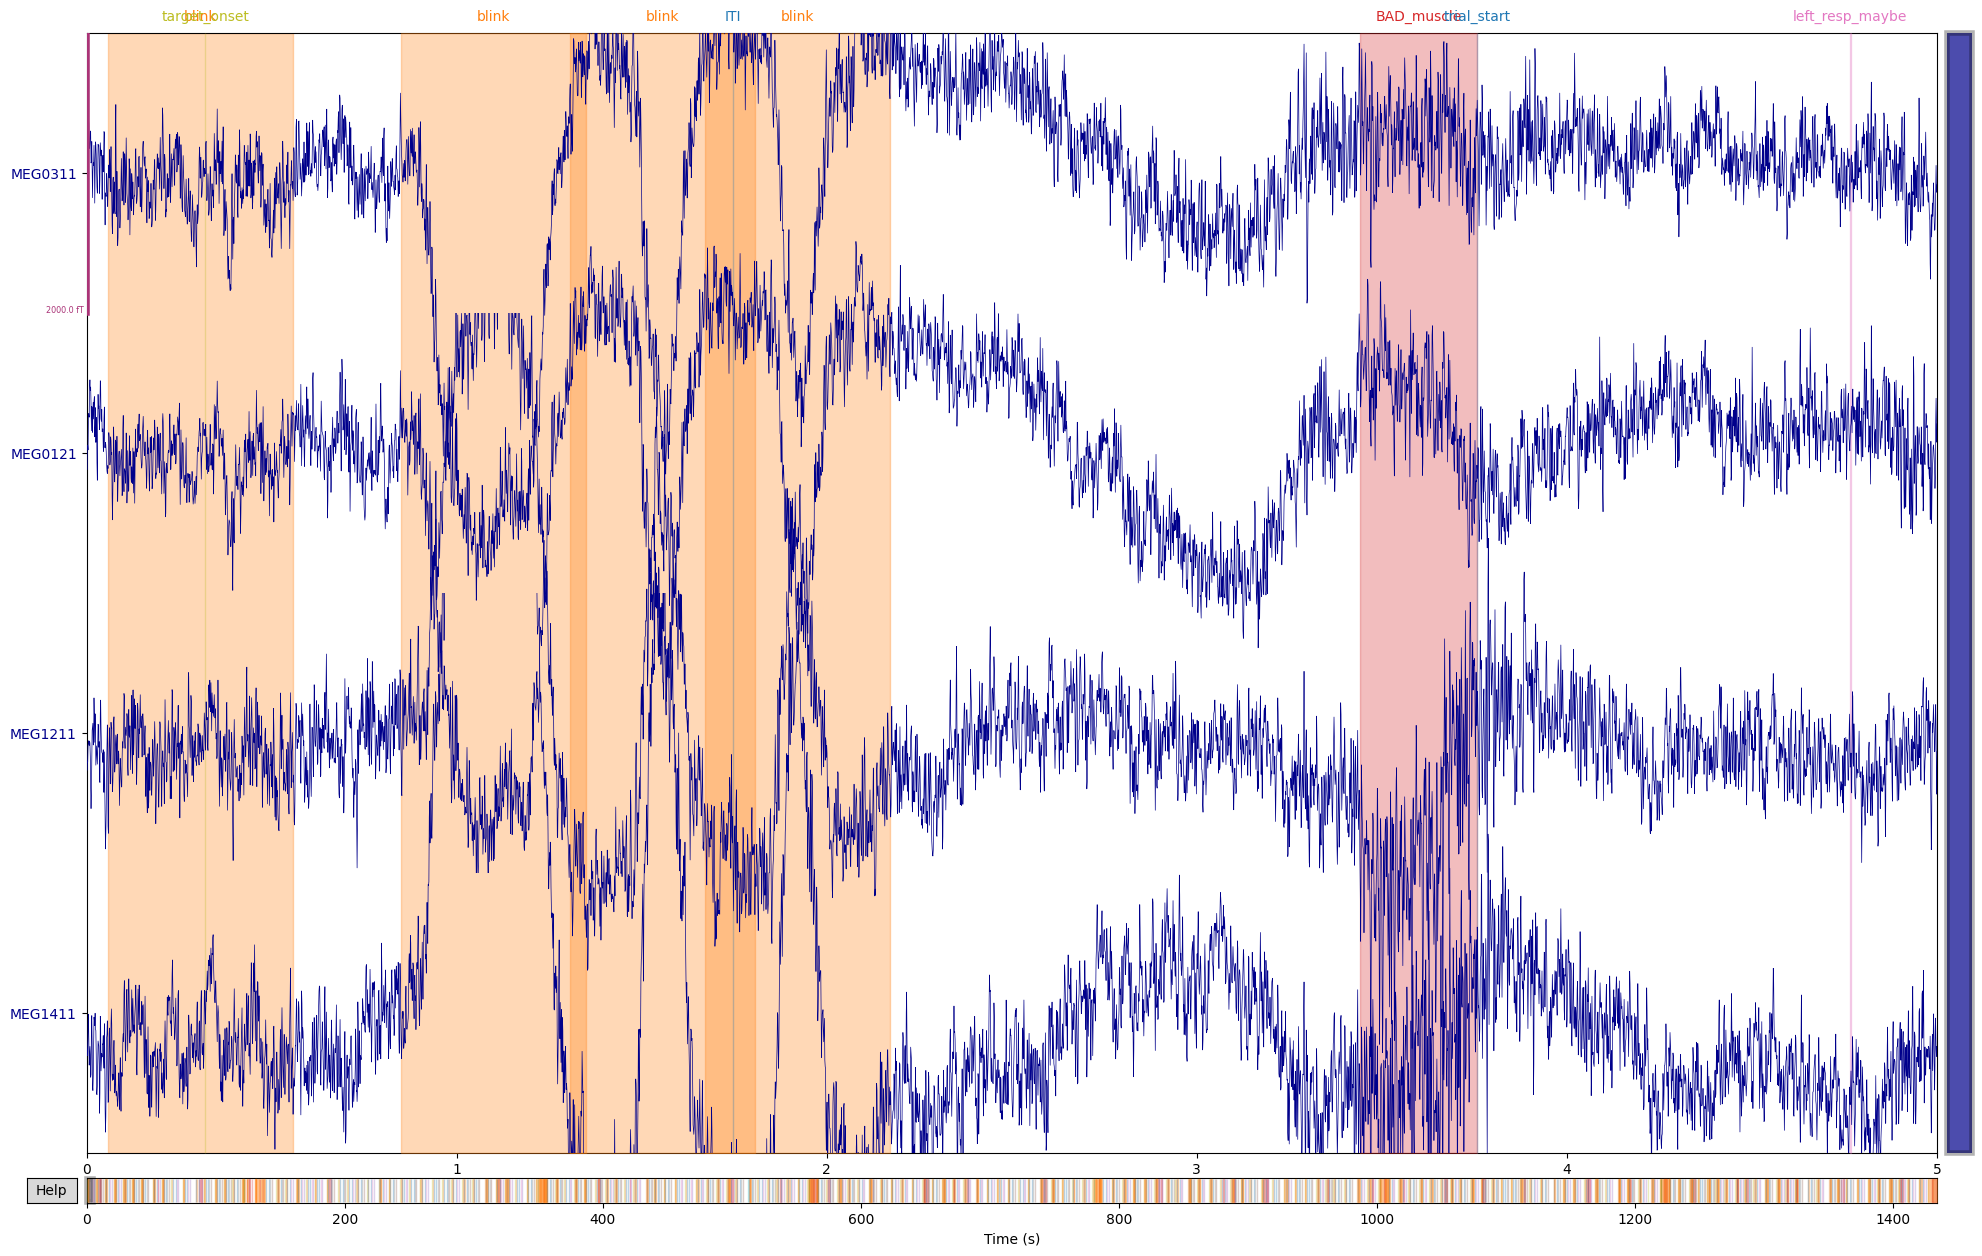

In [23]:
%matplotlib inline
raw.plot(order=chan_idxs, duration=5)

上图显示了应用ICA投影之前的原始轨迹。注意脑磁图数据中的眼部伪影，例如~1秒。

然后在应用ICA投影后绘制相同的轨迹：

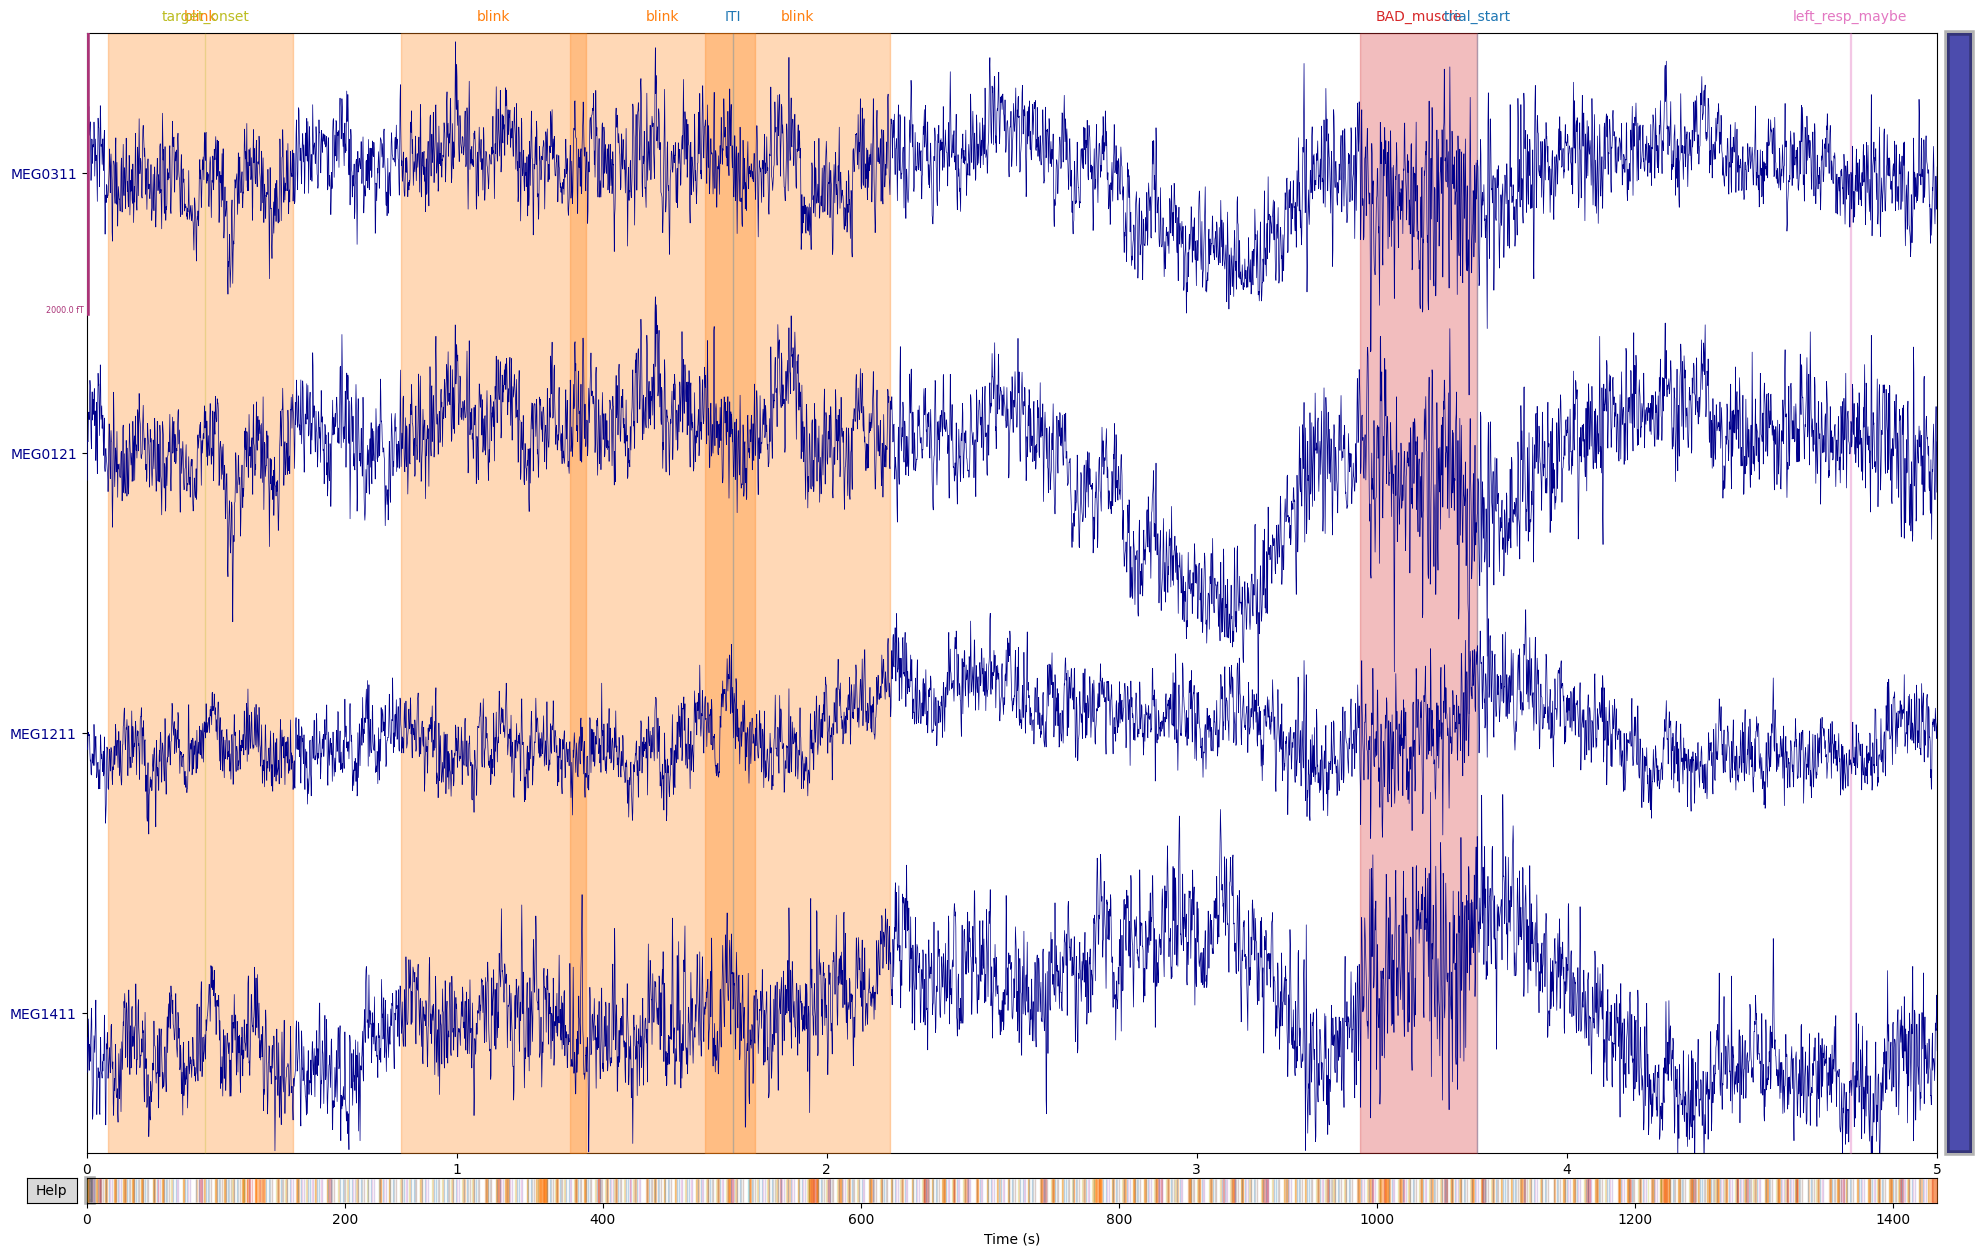

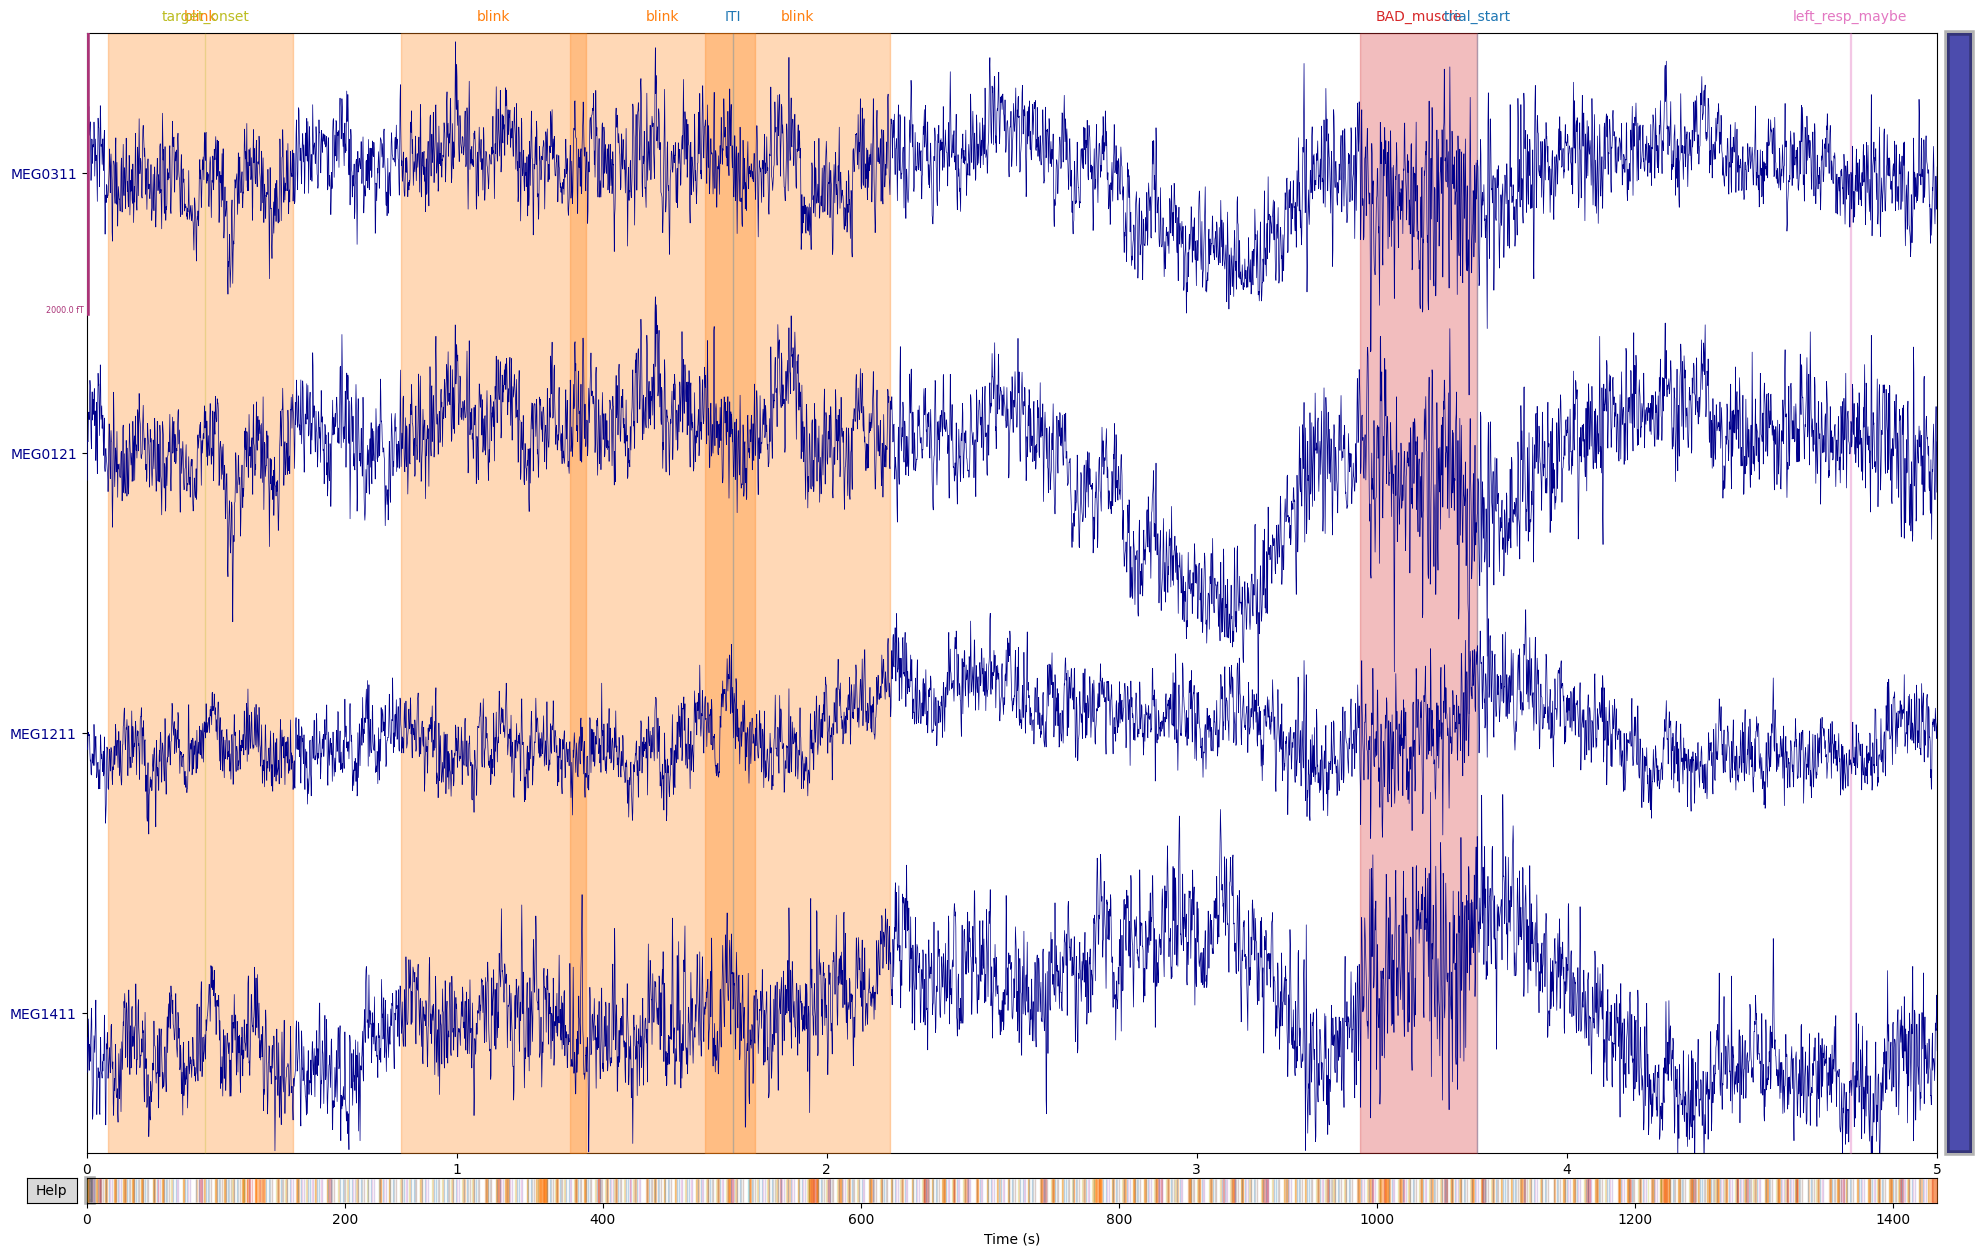

In [24]:
%matplotlib inline
raw_ica.plot(order=chan_idxs, duration=5)

如上图所示，眼部伪影明显减少。

## Preregistration and publication

Example text:  
"The data were down sampled to 200 Hz prior to Independent Component Analysis (ICA) and bandpass filtered at 1 – 40 Hz. Next the fastICA algorithm  (Hyvärinen and Oja, 2000) was applied to the segmented data as implemented in MNE Python. Components containing cardiac artefacts and eyeblinks (identified in time course and topographies of the ICA components) were removed in each subject (3 – 5 over subjects) in the raw unfiltered data. "



## References

* Hyvärinen A, Oja E. (2002) Independent component analysis: algorithms and applications. Neural Netw. 13(4-5):411-30. doi: 10.1016/s0893-6080(00)00026-5. 